In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

from PIL import Image

torch.backends.cudnn.benchmark = True

# Params

In [2]:
CLASSES = ['Healthy', 'OC Degeneration']

load_checkpoints = True

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

# Setup and Load Datasets

In [3]:
relative_model_path = "two4two_sickones_models_pytorch"
base_path = Path('./') / relative_model_path
base_path

PosixPath('two4two_sickones_models_pytorch')

In [4]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(str(self.data_dir), str(self.df.iloc[idx]['filename'])) ## Added str 
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [5]:

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exsists:
      return Path(cache_dir) / archive_folder
    else:
      return Path(cache_dir)

    return Path(file_path)

In [6]:
data_dir = download_file("https://uni-bielefeld.sciebo.de/s/2BgY19ixIaEUOmS/download",
                         "two4two_datasets.tar.gz",
                         cache_dir='data',
                         extract=True,
                         force_download=False,
                         archive_folder='two4two_datasets')

ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

File already exists at: data/two4two_datasets.tar.gz


/tmp/ipykernel_840436/3204753114.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=cache_dir)


File extracted to: data


(PosixPath('data/two4two_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('data/two4two_datasets/sick_ones_bendbias_v3_2class_variation'))

In [7]:
train_df = load_dataframe(ds_dir, 'train')
train_transforms = T.Compose([
    T.ToTensor()
])
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=train_transforms)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True,
                        num_workers=6, pin_memory=True)

# Initialize variables to calculate mean
mean = torch.zeros(3)  # For RGB channels
total_pixels = 0

# Loop through the dataset
for images, _ in tqdm(dataloader):
    # Sum pixel values per channel
    mean += images.sum(dim=[0, 2, 3])
    total_pixels += images.size(0) * images.size(2) * images.size(3)

# Divide by total number of pixels
mean /= total_pixels

print(f"Mean per channel: {mean}")

# Initialize variables for std calculation
std = torch.zeros(3)

# Loop again for standard deviation
for images, _ in tqdm(dataloader):
    std += ((images - mean.view(1, 3, 1, 1))**2).sum(dim=[0, 2, 3])

std = torch.sqrt(std / total_pixels)

print(f"Standard Deviation per channel: {std}")

100%|██████████| 400/400 [00:14<00:00, 27.60it/s]


Mean per channel: tensor([0.8068, 0.7830, 0.8005])


100%|██████████| 400/400 [00:12<00:00, 32.75it/s]

Standard Deviation per channel: tensor([0.1093, 0.1136, 0.1029])


In [8]:
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

In [9]:
len(val_df), len(test_df), len(eval_df), len(train_df)

(1000, 3000, 3000, 40000)

In [10]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [11]:
test_df['filename'] = test_df['filename'].astype(str).str.strip()
for i, fname in enumerate(test_df['filename']):
    if '\n' in fname or ' ' in fname:
        print(f"[WARNING] Bad filename in row {i}: {repr(fname)}")

In [12]:
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

train_eval_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_eval_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,
                                   num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

In [13]:
data_ex = next(iter(train_dataloader))
data_ex[0].shape, data_ex[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## Analysis Dataset

In [14]:
# create column for absolute sphere difference
train_df['sphere_diff'] = np.abs(train_df['spherical'] - train_df['ill_spherical'])
val_df['sphere_diff'] = np.abs(val_df['spherical'] - val_df['ill_spherical'])
test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

# Model Training and Evaluation

In [15]:
def load_resnet50(num_classes, pretrained=True, checkpoint_path=None):
    """Loads a ResNet-50 model, optionally loading from a checkpoint.

    Args:
      num_classes: Number of output classes.
      pretrained: Whether to load pretrained weights.
      checkpoint_path: Path to a checkpoint file to load.

    Returns:
      A ResNet-50 model.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final fully-connected layer

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model


In [16]:
# setup model path
model_path = base_path / ds / f'{modeltype}'
model_path.mkdir(parents=True, exist_ok=True)
print("Model path:", model_path)

Model path: two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet


In [17]:
# setup checkpoint folders
checkpoint_path = model_path / "torch_resnet50/"
(checkpoint_path / 'tmp').mkdir(parents=True, exist_ok=True)
(checkpoint_path / 'final').mkdir(parents=True, exist_ok=True)

In [18]:
# Define loss function
criterion = nn.CrossEntropyLoss()
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# load best model and evaluate

model = load_resnet50(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device)

Loaded checkpoint from: two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_resnet50/final/best_model.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### CRP Explaination

In [20]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

import torchvision
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization

In [21]:
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)
cc = ChannelConcept()

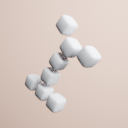

In [22]:
image = Image.open("data/two4two_datasets/sick_ones_bendbias/test/0a1d34d9-6cf6-4c31-a17b-2063724d079f.png")
image

In [23]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)

#transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
#preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
test_df['filename'] = test_df['filename'].astype(str).str.strip().str.split().str[-1] 

Blockies_data =  ImageDataset(test_df,  ds_dir / 'test', transform=transform)

In [25]:
fv_path = "ResNet_Blockies"
fv = FeatureVisualization(attribution, Blockies_data, layer_map, path=fv_path)

In [26]:
saved_files = fv.run(composite, 0, len(Blockies_data), 32, 100)

Running Analysis...


100%|██████████| 94/94 [01:19<00:00,  1.19it/s]


100%|██████████| 108/108 [00:00<00:00, 1201.10it/s]


In [27]:
%matplotlib inline
from crp.image import plot_grid

In [29]:
layer_names

['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.0.downsample.0',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.1.conv3',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer1.2.conv3',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.conv3',
 'layer2.0.downsample.0',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.1.conv3',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.2.conv3',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer2.3.conv3',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.conv3',
 'layer3.0.downsample.0',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.1.conv3',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.2.conv3',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.3.conv3',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.4.conv3',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer3.5.conv3',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.conv3',
 'layer4.0.downsample.0',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.1.conv3',
 'layer4.2.conv1',
 'layer4.2.c

The plot_grid function converts tensors of images and heatmaps to PIL.Image files automatically using the crp.imgify function. Thus, you will find all necessary paramters of crp.imgify also in plot_grid

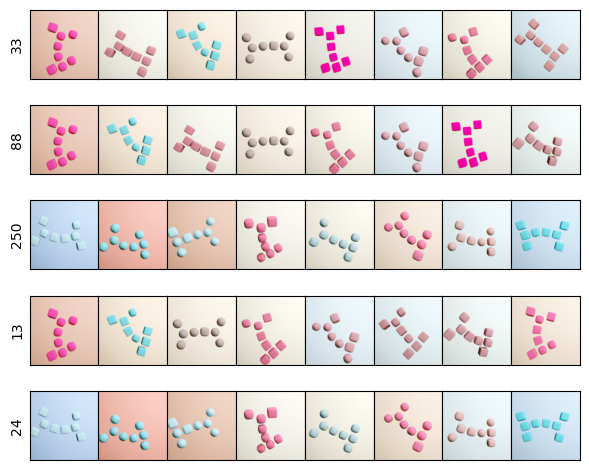

: 

In [ ]:
ref_c = fv.get_max_reference([33,  88, 250,  13, 24], "layer4.0.conv2", "relevance", (0, 8))

plot_grid(ref_c, figsize=(6, 5), padding=False)

### Conditonal Heatmaps on Reference Samples

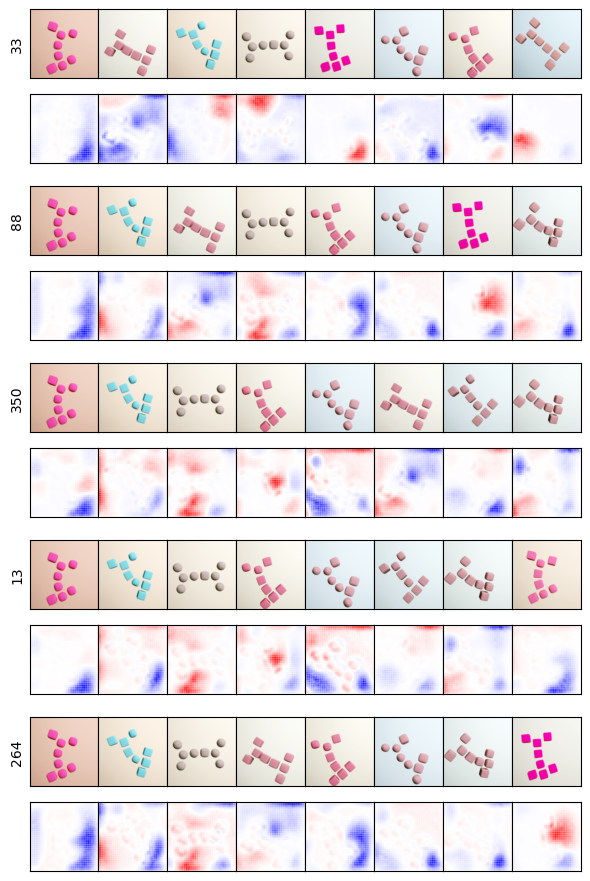

In [45]:
ref_c = fv.get_max_reference([33,  88, 350,  13, 264],  'layer4.0.conv2', 'relevance', (0,8), composite=composite, plot_fn=None)

plot_grid(ref_c, figsize=(6, 9))

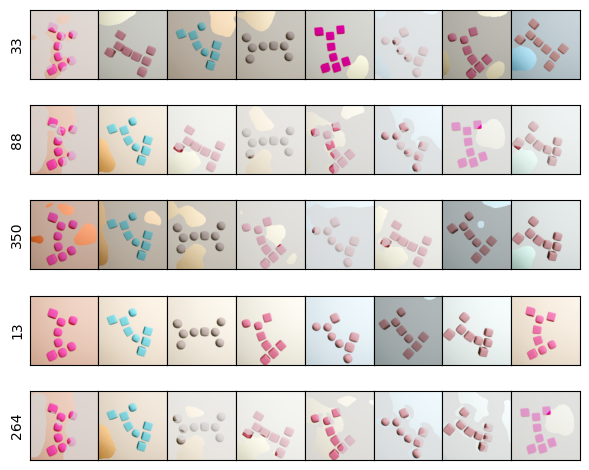

In [40]:
from crp.image import vis_opaque_img

ref_c = fv.get_max_reference([33,  88, 350,  13, 264],  'layer4.0.conv2', "relevance", (0, 8), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(6, 5))

### TODO: Investigate layer selection + topk concepts ID to Enhance the explanation results